In [1]:
using Bloqade
using Random
using PythonCall
plt = pyimport("matplotlib.pyplot");

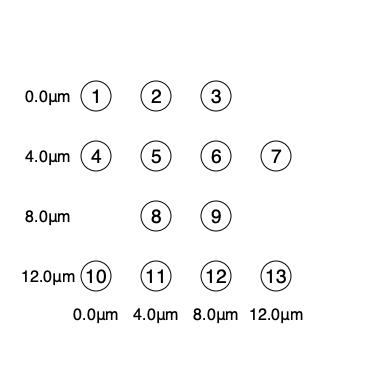

In [131]:
Random.seed!(14)
a=4
atoms = generate_sites(SquareLattice(), 4,4; scale = a) |> random_dropout(0.2)

In [132]:
Rb=sqrt(3*sqrt(10))*a

12.320281152964093

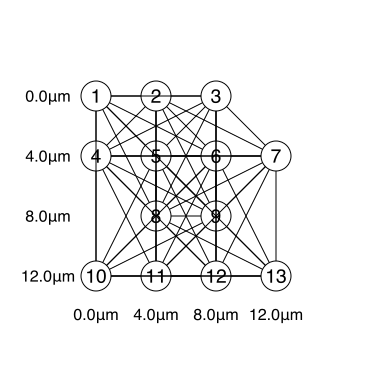

In [133]:
Bloqade.plot(atoms, blockade_radius = Rb)

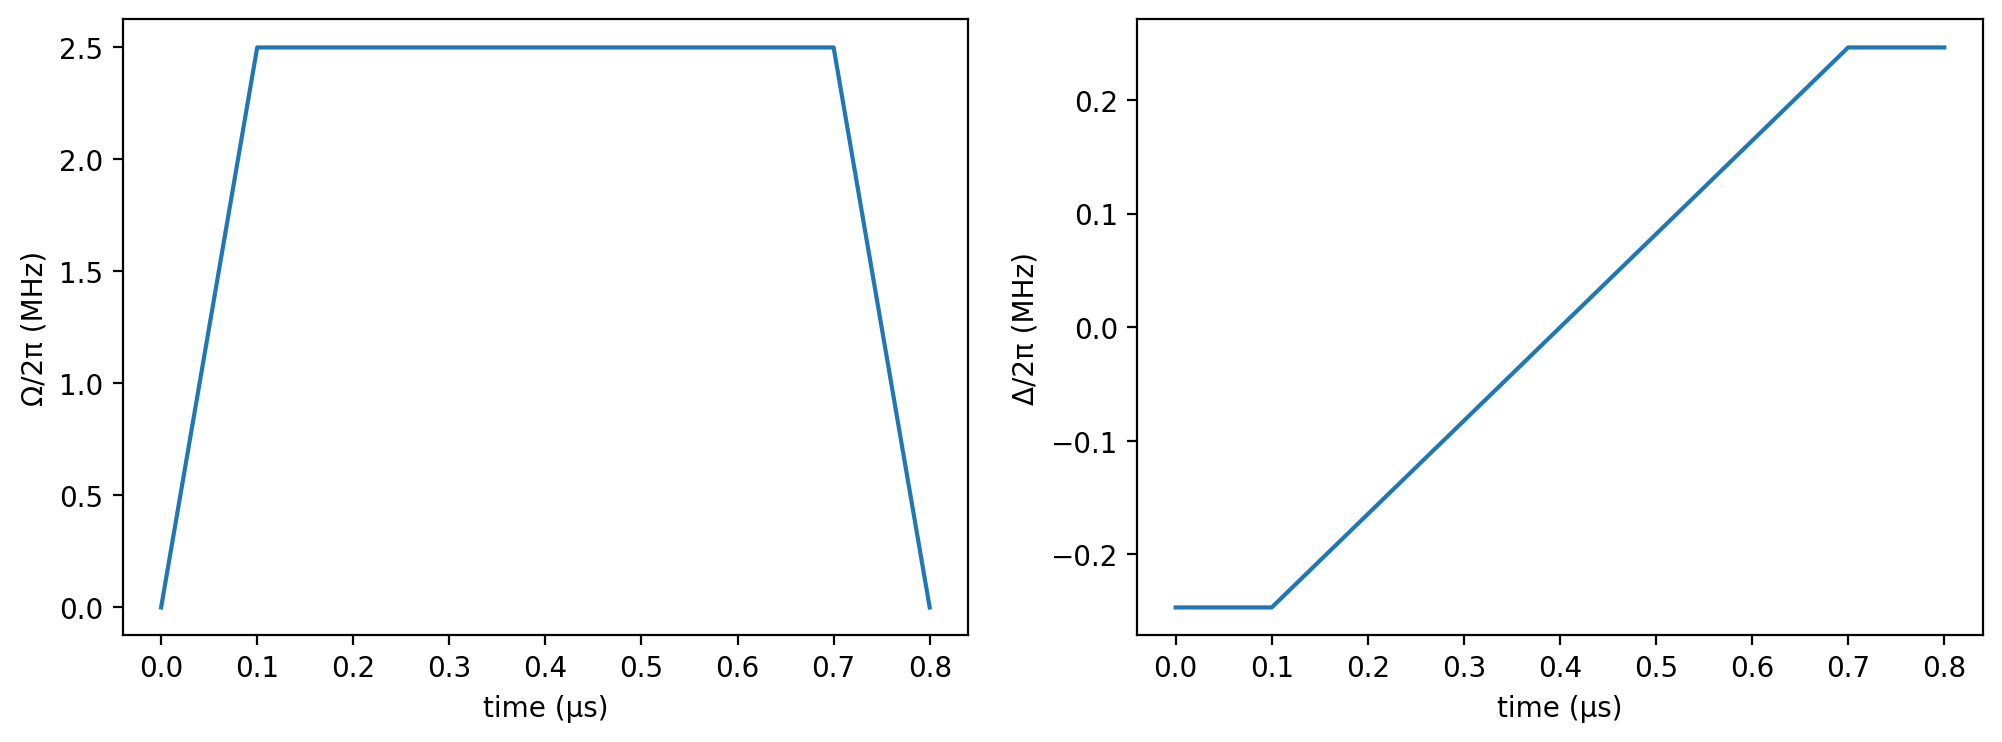

In [155]:
#Total evolution time
T_max = 0.8

#Fix Δ according to the desired Rydberg radius
C6 = 2π * 862690;
Ω_max = 2π*2.5
Δ_max = C6 / Rb^6

#Build time traces for adiabatic algorithm
Ω = piecewise_linear(clocks = [0.0, 0.1, 0.7, T_max], values = [0.0, Ω_max, Ω_max, 0])
Δ_start = -Δ_max
Δ_end = Δ_max
Δ = piecewise_linear(clocks = [0.0, 0.1, 0.7, T_max], values = [Δ_start, Δ_start, Δ_end, Δ_end])

#Quick plot to check
fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [156]:
h_kings = rydberg_h(atoms; Ω = Ω, Δ = Δ)
prob = SchrodingerProblem(zero_state(nqubits(h_kings)), T_max, h_kings);

In [157]:
emulate!(prob)

SchrodingerProblem:
  register info:
    type: ArrayReg{2, ComplexF64, Matrix{ComplexF64}}
    storage size: 8 bytes

  time span (μs): (0.0, 0.8)

  equation: 
    storage size: 1.688 MiB
    expression:
nqubits: 13
+
├─ [+] ∑ 2π ⋅ 8.627e5.0/|x_i-x_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


    algorithm: DP8(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false),)
  options:
    save_everystep: false
    save_start: false
    save_on: false
    dense: false
    reltol: 1.0e-10
    abstol: 1.0e-10
    alias_u0: true


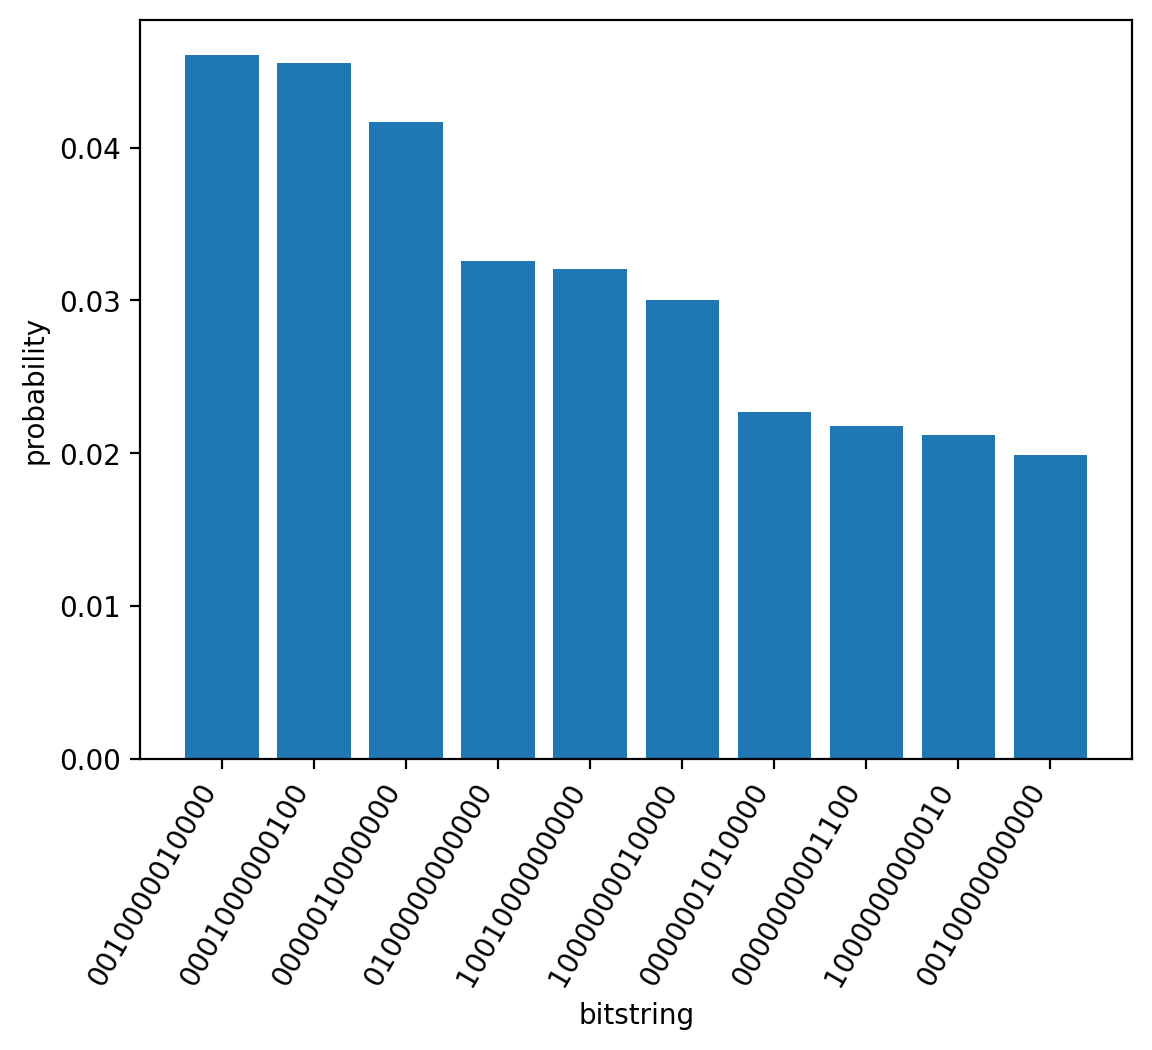

In [158]:
bitstring_hist(prob.reg; nlargest = 10)

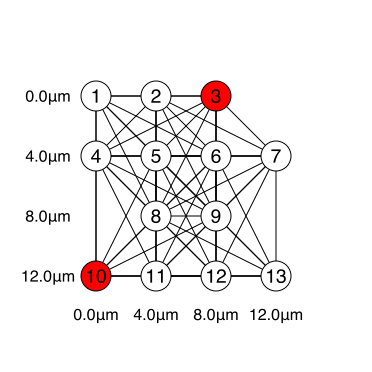

In [159]:
best_bit_strings = most_probable(prob.reg, 3)

Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[2]])

In [160]:
graph = BloqadeMIS.unit_disk_graph(atoms, Rb)

{13, 66} undirected simple Int64 graph

In [161]:
using GenericTensorNetworks
problem = IndependentSet(graph; optimizer=TreeSA())

IndependentSet{OMEinsum.SlicedEinsum{Int64, OMEinsum.DynamicNestedEinsum{Int64}}, NoWeight}(OMEinsum.SlicedEinsum{Int64, OMEinsum.DynamicNestedEinsum{Int64}}(Int64[], 2, 2 -> 
├─ 8, 2∘8 -> 2
│  ├─ 8
│  └─ 2∘8, 8∘2 -> 2∘8
│     ├─ 2∘8
│     └─ 2∘5∘8, 2∘5 -> 8∘2
│        ├─ 6∘5∘8, 8∘2∘5∘6 -> 2∘5∘8
│        │  ├─ 5∘8∘6, 5∘8 -> 6∘5∘8
│        │  │  ⋮
│        │  │  
│        │  └─ 4∘2∘3∘5∘6∘1, 1∘2∘5∘6∘4∘3∘8 -> 8∘2∘5∘6
│        │     ⋮
│        │     
│        └─ 2∘5, 5 -> 2∘5
│           ├─ 2∘5
│           └─ 5
└─ 2
), Graphs.SimpleGraphs.SimpleGraph{Int64}(66, [[2, 3, 4, 5, 6, 8, 9, 10], [1, 3, 4, 5, 6, 7, 8, 9, 11], [1, 2, 4, 5, 6, 7, 8, 9, 12], [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12], [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13], [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13], [2, 3, 4, 5, 6, 8, 9, 11, 12, 13], [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13], [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13], [1, 4, 5, 6, 8, 9, 11, 12, 13], [2, 4, 5, 6, 7, 8, 9, 10, 12, 13], [3, 4, 5, 6, 7, 8, 9, 10, 11, 13], [5, 6

In [162]:
maximum_independent_set_size = GenericTensorNetworks.solve(problem, SizeMax())[]

2.0ₜ

In [163]:
count_maximum_independent_sets = GenericTensorNetworks.solve(problem, CountingMax())[]

(2.0, 12.0)ₜ

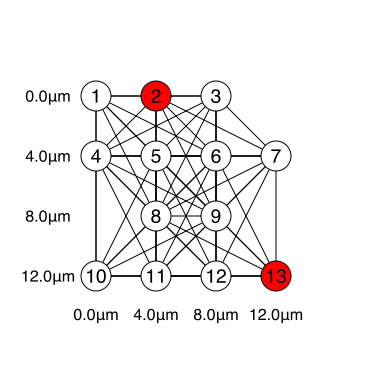

In [164]:
max_config = GenericTensorNetworks.solve(problem, SingleConfigMax(; bounded=false))[]
Bloqade.plot(atoms, blockade_radius = Rb; colors = [iszero(b) ? "white" : "red" for b ∈ max_config.c.data])